Processing ../../models/chunk_3/republican_before_2016.model...
Processing ../../models/chunk_3/republican_2017_2020.model...
Processing ../../models/chunk_3/republican_2021_2024.model...
Generating comparison plot...


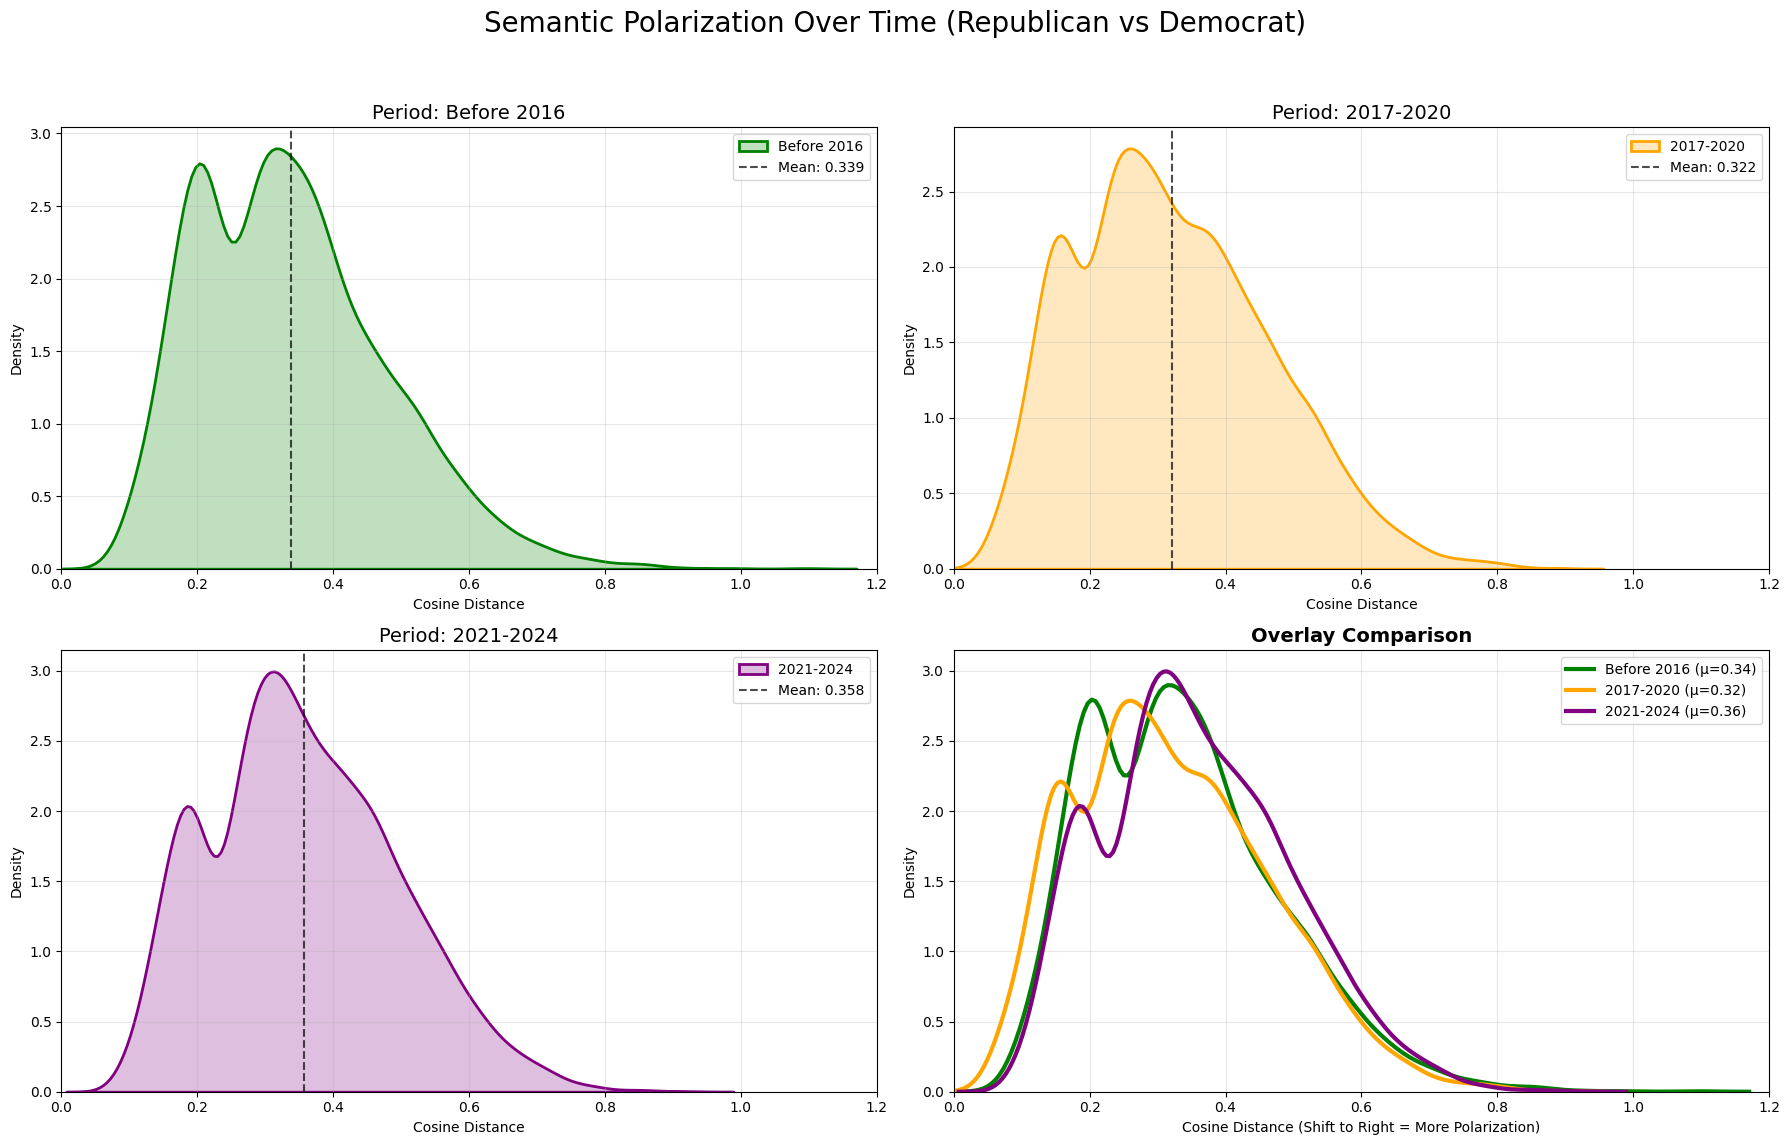

In [65]:
import gensim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Configuration ---
periods = [
    {
        "name": "Before 2016",
        "rep": "../../models/chunk_3/republican_before_2016.model",
        "dem": "../../models/chunk_3/democrats_before_2016.model",
        "color": "green"
    },
    {
        "name": "2017-2020",
        "rep": "../../models/chunk_3/republican_2017_2020.model",
        "dem": "../../models/chunk_3/democrats_2017_2020.model",
        "color": "orange"
    },
    {
        "name": "2021-2024",
        "rep": "../../models/chunk_3/republican_2021_2024.model",
        "dem": "../../models/chunk_3/democrats_2021_2024.model",
        "color": "purple"
    }
]

# --- Helper Functions (Your existing logic) ---
def get_processed_vectors(model, words, center=True):
    vecs = np.array([model.wv[word] for word in words])
    if center:
        vecs = vecs - vecs.mean(axis=0)
    norm = np.linalg.norm(vecs, axis=1, keepdims=True)
    norm[norm == 0] = 1 
    return vecs / norm

def align_and_measure(path_rep, path_dem):
    # 1. Load
    print(f"Processing {path_rep}...")
    model_rep = gensim.models.Word2Vec.load(path_rep)
    model_dem = gensim.models.Word2Vec.load(path_dem)

    # 2. Rough Alignment
    # Filter to top 60% by frequency in each model
    rep_vocab_sorted = sorted(model_rep.wv.index_to_key, key=lambda w: model_rep.wv.get_vecattr(w, "count"), reverse=True)
    dem_vocab_sorted = sorted(model_dem.wv.index_to_key, key=lambda w: model_dem.wv.get_vecattr(w, "count"), reverse=True)
    
    num_rep = int(0.6 * len(rep_vocab_sorted))
    num_dem = int(0.6 * len(dem_vocab_sorted))
    
    top_rep = set(rep_vocab_sorted[:num_rep])
    top_dem = set(dem_vocab_sorted[:num_dem])
    
    common_vocab = list(top_rep.intersection(top_dem))
    
    # Sort by frequency sum
    common_vocab.sort(key=lambda w: model_rep.wv.get_vecattr(w, "count") + model_dem.wv.get_vecattr(w, "count"), reverse=True)
    
    # Anchors
    initial_anchors = common_vocab[:3000]
    
    # 3. First Rotation
    vecs_rep_rough = get_processed_vectors(model_rep, initial_anchors, center=True)
    vecs_dem_rough = get_processed_vectors(model_dem, initial_anchors, center=True)
    
    m = vecs_dem_rough.T @ vecs_rep_rough
    u, _, vt = np.linalg.svd(m)
    rotation_1 = u @ vt
    vecs_dem_rotated = vecs_dem_rough @ rotation_1
    
    # 4. Filter Anchors
    similarities = np.sum(vecs_rep_rough * vecs_dem_rotated, axis=1)
    distances = 1 - similarities
    anchor_scores = sorted(zip(initial_anchors, distances), key=lambda x: x[1])
    refined_anchors = [w for w, d in anchor_scores[:1500]]
    
    # 5. Final Alignment
    vecs_rep_final = get_processed_vectors(model_rep, refined_anchors, center=True)
    vecs_dem_final = get_processed_vectors(model_dem, refined_anchors, center=True)
    
    m_final = vecs_dem_final.T @ vecs_rep_final
    u_final, _, vt_final = np.linalg.svd(m_final)
    rotation_final = u_final @ vt_final
    
    # Apply Rotation & Translation
    model_dem.wv.vectors = model_dem.wv.vectors @ rotation_final
    
    mean_rep = np.mean(model_rep.wv[refined_anchors], axis=0)
    mean_dem = np.mean(model_dem.wv[refined_anchors], axis=0)
    model_dem.wv.vectors = model_dem.wv.vectors + (mean_rep - mean_dem)
    
    if hasattr(model_dem.wv, 'fill_norms'):
        model_dem.wv.fill_norms(force=True)
    
    # 6. Measure Distances
    # Take top 90% by frequency to avoid noise in plotting
    num_anchors = int(0.8 * len(common_vocab))
    analysis_vocab = common_vocab[:num_anchors]
    
    vecs_rep_all = get_processed_vectors(model_rep, analysis_vocab, center=True)
    vecs_dem_all = get_processed_vectors(model_dem, analysis_vocab, center=True)
    
    all_distances = 1 - np.sum(vecs_rep_all * vecs_dem_all, axis=1)
    
    return all_distances, analysis_vocab

# --- Main Execution Loop ---
results = {}

for period in periods:
    dists, vocab = align_and_measure(period["rep"], period["dem"])
    results[period["name"]] = dists

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Semantic Polarization Over Time (Republican vs Democrat)', fontsize=20)

axes_flat = axes.flatten()

# Loop for the first 3 individual plots
for i, period in enumerate(periods):
    ax = axes_flat[i]
    dists = results[period["name"]]
    name = period["name"]
    color = period["color"]
    
    # Plot Histogram / KDE
    sns.kdeplot(dists, ax=ax, fill=True, color=color, label=name, linewidth=2)
    
    # Add mean line
    mean_val = np.mean(dists)
    ax.axvline(mean_val, color='black', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.3f}')
    
    ax.set_title(f'Period: {name}', fontsize=14)
    ax.set_xlabel('Cosine Distance')
    ax.set_xlim(0, 1.2) # Fix x-axis so they are visually comparable
    ax.legend()
    ax.grid(True, alpha=0.3)

# The 4th Plot: Overlay (Comparison)
ax_final = axes_flat[3]
print("Generating comparison plot...")

for period in periods:
    dists = results[period["name"]]
    sns.kdeplot(dists, ax=ax_final, fill=False, linewidth=3, label=f'{period["name"]} (μ={np.mean(dists):.2f})', color=period["color"])

ax_final.set_title('Overlay Comparison', fontsize=14, fontweight='bold')
ax_final.set_xlabel('Cosine Distance (Shift to Right = More Polarization)')
ax_final.set_xlim(0, 1.2)
ax_final.legend()
ax_final.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Make room for suptitle
plt.show()

In [64]:
import gensim
import numpy as np
import pandas as pd

# Load your 2021-2024 models (assuming you saved the aligned version!)
# If not, you need to re-run the alignment code first.
# For this example, I assume model_dem is already aligned in memory.
path_rep = "../../models/chunk_3/republican_2021_2024.model"
path_dem = "../../models/chunk_3/democrats_2021_2024.model"

model_rep = gensim.models.Word2Vec.load(path_rep)
model_dem = gensim.models.Word2Vec.load(path_dem)

def get_neighbors(model, word, topn=5):
    try:
        return [w for w, s in model.wv.most_similar(word, topn=topn)]
    except:
        return []

# 1. Identify the most polarized words (Top 50 by distance)
# (Assuming you have 'all_distances' and 'vocab' from the previous script)
df_drivers = pd.DataFrame({'word': vocab, 'distance': dists})
top_drivers = df_drivers.sort_values('distance', ascending=False).head(50)

print("--- Top Polarization Drivers (2021-2024) ---")

for index, row in top_drivers.iterrows():
    word = row['word']
    dist = row['distance']
    
    # Get context from both sides
    neighbors_rep = get_neighbors(model_rep, word)
    neighbors_dem = get_neighbors(model_dem, word) # This model must be the ALIGNED one
    
    print(f"\nWord: {word.upper()} (Distance: {dist:.3f})")
    print(f"  Rep sees it close to: {', '.join(neighbors_rep)}")
    print(f"  Dem sees it close to: {', '.join(neighbors_dem)}")


--- Top Polarization Drivers (2021-2024) ---

Word: BALDWIN (Distance: 0.923)
  Rep sees it close to: alec, chauvin, alec_baldwin, rittenhouse, kyle
  Dem sees it close to: sen, sen_mike, michael_bennet, jon_ossoff, raphael_warnock

Word: INCIDENTALLY (Distance: 0.892)
  Rep sees it close to: amusingly, authorize, aid_package, facilitate, biolabs
  Dem sees it close to: jared_moskowitz, corey_booker, klanned_karenhood, torres, jagoff

Word: ROYALTY (Distance: 0.877)
  Rep sees it close to: artificially_low, mortgage, earner, student_debt, yearly
  Dem sees it close to: cheapskate, golf_tournament, private_jet, llc, levin

Word: DEA (Distance: 0.866)
  Rep sees it close to: serbia, luna, sock_puppet, ronna_mcdaniel, infiltrator
  Dem sees it close to: justice_department, reschedule, hhs, doj, fda

Word: CASEY (Distance: 0.850)
  Rep sees it close to: emanation, roe, griswold, statutory_authority, penumbra
  Dem sees it close to: tester, masto, ruben_gallego, jon_tester, colin_allred

Wo

In [60]:
word = 'oblige'
path_rep = "../../models/chunk_3/republican_2021_2024.model"
path_dem = "../../models/chunk_3/democrats_2021_2024.model"

model_rep = gensim.models.Word2Vec.load(path_rep)
model_dem = gensim.models.Word2Vec.load(path_dem)

if word in model_rep.wv:
    count_rep = model_rep.wv.get_vecattr(word, "count")
    print(f"'{word}' appears {count_rep} times in the Republican model.")
else:
    print(f"'{word}' not found in the Republican model.")

if word in model_dem.wv:
    count_dem = model_dem.wv.get_vecattr(word, "count")
    print(f"'{word}' appears {count_dem} times in the Democrat model.")
else:
    print(f"'{word}' not found in the Democrat model.")


'oblige' appears 27 times in the Republican model.
'oblige' appears 86 times in the Democrat model.


In [66]:
import os

for period in periods:
    name = period["name"]
    dists = results[name]
    vocab = align_and_measure(period["rep"], period["dem"])[1]  # Get vocab again, or store it earlier
    
    # Load models to get neighbors
    model_rep = gensim.models.Word2Vec.load(period["rep"])
    model_dem = gensim.models.Word2Vec.load(period["dem"])
    
    # Create DataFrame
    df = pd.DataFrame({'word': vocab, 'distance': dists})
    df = df.sort_values('distance', ascending=False)  # Max to min
    
    # Add neighbors
    def get_neighbors_str(model, word, topn=5):
        try:
            neighbors = [w for w, s in model.wv.most_similar(word, topn=topn)]
            return ', '.join(neighbors)
        except:
            return ''
    
    df['rep_neighbors'] = df['word'].apply(lambda w: get_neighbors_str(model_rep, w))
    df['dem_neighbors'] = df['word'].apply(lambda w: get_neighbors_str(model_dem, w))
    
    # Save to CSV
    csv_path = f"../../output/iterative/{name.replace(' ', '_').replace('-', '_')}.csv"
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    df.to_csv(csv_path, index=False)
    print(f"Saved {csv_path}")

Processing ../../models/chunk_3/republican_before_2016.model...
Saved ../../output/iterative/Before_2016.csv
Processing ../../models/chunk_3/republican_2017_2020.model...
Saved ../../output/iterative/2017_2020.csv
Processing ../../models/chunk_3/republican_2021_2024.model...
Saved ../../output/iterative/2021_2024.csv
